# CS 109A/STAT 121A/AC 209A/CSCI E-109A: 
# Final Project - 2017

**Harvard University**<br/>
**Fall 2017**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, Rahul Dave, Margo Levine<br/>
**Leading TF**: Albert Wu<br/>
**Project Group #**: 16 (Sports)

---

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import IFrame, HTML
import requests
from bs4 import BeautifulSoup
import seaborn as sns
import sys
import json

### Part 1: Data Scraping - Do not rerun at re-start ###

In [ ]:
def process_game_play(url):

    game_pd = pd.read_html(url, header=1)[0]

    # Set proper initial headers
    away_team = game_pd.columns[1]
    home_team = game_pd.columns[5]
    game_pd.columns = ['time', 'away_events','away_pts','score','home_pts','home_events']
    game_pd['away_team'] = away_team
    game_pd['home_team'] = home_team

    # Combine home and away team events
    events = game_pd['home_events']
    events = events.fillna(game_pd['away_events'])
    game_pd['events'] = events
    game_pd['is_home_event'] = 1 - pd.isnull(game_pd['home_events'])

    # Fill invalid scores
    game_pd['score'] = game_pd['score'].replace(to_replace='Score',method='ffill')
    game_pd['score'] = game_pd['score'].fillna(method='backfill')
    game_pd = game_pd.drop(game_pd.index[game_pd['score'].isnull()], axis=0)

    # Process scores
    score_str = game_pd['score'].str.split('-').tolist()
    away_score,home_score = np.transpose(np.array(score_str))
    away_score = away_score.astype(int)
    home_score = home_score.astype(int)
    away_score[:2] = 0
    home_score[:2] = 0
    game_pd['away_score'] = away_score
    game_pd['home_score'] = home_score
    game_pd['score_diff'] = home_score - away_score
    game_pd['home_win'] = (home_score[-1] > away_score[-1]).astype(int)

    # Drop useless columns
    game_pd = game_pd.drop(['away_events', 'away_pts', 'score', 'home_pts', 'home_events'], axis=1)
    
    # Drop the remaining headers rows
    #if any(game_pd['time'].str.contains('Time')):
    ind_header = game_pd.index[game_pd['time'].str.contains('Time')]
    game_pd = game_pd.drop(ind_header, axis=0).reset_index(drop=True)
    #game_pd.reset_index(drop=True)
    
    # Calculate elapsed time
    game_pd['t_elapsed'] = game_pd['time'].str.split(':')
    game_pd = game_pd.drop(game_pd.index[game_pd['time'].str.contains('1st Q')], axis=0).reset_index(drop=True)
    quarter_str = ['2nd Q', '3rd Q', '4th Q', '1st OT', '2nd OT', '3rd OT', '4th OT', '5th OT', '6th OT']
    last_ind = 0
    for i in range(len(quarter_str)):
        if any(game_pd['time'].str.contains(quarter_str[i])):
            ind_list = game_pd.index[game_pd['time'].str.contains(quarter_str[i])]
            ind_Q = ind_list[0]
            game_pd = game_pd.drop(np.arange(ind_Q-1, ind_Q+2, 1).tolist(), axis=0)
            # Special case where multiple 'i-th Q' in the table
            # See https://www.basketball-reference.com/boxscores/pbp/201611110BOS.html
            for j in range(1, len(ind_list)):
                game_pd = game_pd.drop(ind_list[j], axis=0)
                
            game_pd.loc[last_ind:ind_Q, 't_elapsed'] = game_pd.loc[last_ind:ind_Q, 't_elapsed'].apply(
                lambda s: 720*np.min([4, i+1]) + 300*np.max([0, i-3]) - (float(s[0])*60+float(s[1])))
            last_ind = ind_Q
        else:
            last_Q = i
            break
    game_pd.loc[last_ind:, 't_elapsed'] = game_pd.loc[last_ind:, 't_elapsed'].apply(
        lambda s: 720*4 + 300*np.max([0, last_Q-3]) - (float(s[0])*60+float(s[1])))
    game_pd = game_pd.drop(0, axis=0).reset_index(drop=True)

    # Process event information
    event_type = ['makes', 'miss', '2-pt', '3-pt', 'free throw', 'assist', 'Defensive rebound', 
                  'Offensive rebound', 'Turnover', 'foul']
    for e in event_type:
        game_pd[e.replace(' ', '_')] = game_pd['events'].str.contains(e).astype(int)

    game_pd['substitution'] = game_pd['events'].str.contains('enters the game for').astype(int)
    game_pd['timeout'] = game_pd['events'].str.contains('full timeout').astype(int)
    
    # Calculate Shooting percetage
    home_perc = (game_pd['is_home_event']*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/(game_pd['is_home_event']*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    home_perc = home_perc.fillna(0)
    away_perc = ((1-game_pd['is_home_event'])*(game_pd['makes']*(1-game_pd['free_throw']))).cumsum()/((1-game_pd['is_home_event'])*(game_pd['makes']+game_pd['miss']-game_pd['free_throw'])).cumsum()
    away_perc = away_perc.fillna(0)

    game_pd['home_perc'] = home_perc
    game_pd['away_perc'] = away_perc
    
    return game_pd


In [ ]:
# Process all games from 2014-2015, 2015-2016, 2016-2017 season

url_base = 'https://www.basketball-reference.com/leagues/NBA_year_games-month.html'

years = ['2015', '2016', '2017']
months = ['october', 'november', 'december', 'january', 'february', 'march', 
         'april', 'may', 'june']

game_urls = []
count = 0
for y in years:
    for m in months:
        url_schedule = url_base.replace('year', y)
        url_schedule = url_schedule.replace('month', m)
        response = requests.get(url_schedule)
        soup = BeautifulSoup(response.text, 'lxml')
        for ref in soup.find_all('a'):
            link = ref.get('href')
            if link.startswith('/boxscores/2'):
                game_urls.append('https://www.basketball-reference.com' + link.replace('boxscores/', 'boxscores/pbp/'))
        count += 1
        sys.stdout.write("\rProgress: %.3f%%" % (100*count/(len(years)*len(months))))
        sys.stdout.flush()

In [ ]:
len(game_urls)

In [ ]:
# Don't rerun this at re-start
# This will take a long time
game_pd_dict = dict()
for ind in range(len(game_urls)):
    game_pd_dict['game_%d' % ind] = process_game_play(game_urls[ind])
    sys.stdout.write("\rProgress: %.3f%%" % (100*(ind+1)/len(game_urls)))
    sys.stdout.flush()

In [ ]:
print(len(game_pd_dict))
game_pd_dict['game_0'].head()

In [ ]:
# Save all the game DataFrames into a xlsx file
writer = pd.ExcelWriter('game_pd_dict.xlsx')
counter = 0
for game in game_pd_dict:
    game_pd_dict[game].to_excel(writer, game)
    counter += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()
writer.save()
del game_pd_dict

### Part 2: Load Saved Data - Re-run this at re-start ###

In [4]:
# Read all Processed DataFrame back
game_pd_dict = pd.read_excel('game_pd_dict.xlsx', sheetname=None)

In [5]:
len(game_pd_dict)

3936

In [27]:
t_range = np.arange(0, 2880, 1)
l_range = np.arange(-40, 40, 1)

win_count = np.zeros((len(l_range), len(t_range)))
game_count = np.zeros((len(l_range), len(t_range)))

count = 0

for game in game_pd_dict:
    game_pd = game_pd_dict[game]
    t_game = game_pd['t_elapsed'].values
    l_game = game_pd['score_diff'].values - l_range.min()
    home_win = game_pd.loc[0, 'home_win']
    
    win_count_temp = np.zeros((len(l_range), len(t_range)))
    game_count_temp = np.zeros((len(l_range), len(t_range)))

    for ind in range(len(game_pd)):
        win_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)-1]), 
                       np.max([t_game[ind]-2, 0]):np.min([t_game[ind]+2, len(t_range)-1])] = home_win
        game_count_temp[np.max([l_game[ind]-2, 0]):np.min([l_game[ind]+2, len(l_range)-1]), 
                        np.max([t_game[ind]-2, 0]):np.min([t_game[ind]+2, len(t_range)-1])] = 1
    
    win_count += win_count_temp
    game_count += game_count_temp
    
    count += 1
    sys.stdout.write("\rProgress: %.3f%%" % (100*count/len(game_pd_dict)))
    sys.stdout.flush()

Progress: 100.000%

In [28]:
game_pd.tail()

,time,away_team,home_team,events,is_home_event,away_score,home_score,score_diff,home_win,t_elapsed,...,free_throw,assist,Defensive_rebound,Offensive_rebound,Turnover,foul,substitution,timeout,home_perc,away_perc
449,0:42.0,Cleveland,Golden State,S. Curry makes 3-pt shot from 26 ft,1,115,129,14,1,2838,...,0,0,0,0,0,0,0,0,0.516854,0.523256
450,0:37.0,Cleveland,Golden State,L. James makes 2-pt shot from 2 ft,0,117,129,12,1,2843,...,0,0,0,0,0,0,0,0,0.516854,0.528736
451,0:21.0,Cleveland,Golden State,S. Curry misses 3-pt shot from 24 ft,1,117,129,12,1,2859,...,0,0,0,0,0,0,0,0,0.511111,0.528736
452,0:20.0,Cleveland,Golden State,Defensive rebound by T. Thompson,0,117,129,12,1,2860,...,0,0,1,0,0,0,0,0,0.511111,0.528736
453,0:16.0,Cleveland,Golden State,J. Smith makes 3-pt shot from 24 ft (assist by...,0,120,129,9,1,2864,...,0,1,0,0,0,0,0,0,0.511111,0.534091


In [32]:
win_count[0:21, :][win_count[0:21, :] > 0] += 1
win_count[21:61, :][win_count[21:61, :] > 0] += 2
win_count[61:80, :][win_count[61:80, :] > 0] += 3
game_count[game_count > 0] += 4

In [33]:
win_perc = np.flip(win_count/game_count, 0)

D:\ProgramData\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


D:\ProgramData\Anaconda3\envs\py36\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The spectral and spectral_r colormap was deprecated in version 2.0. Use nipy_spectral and nipy_spectral_r instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


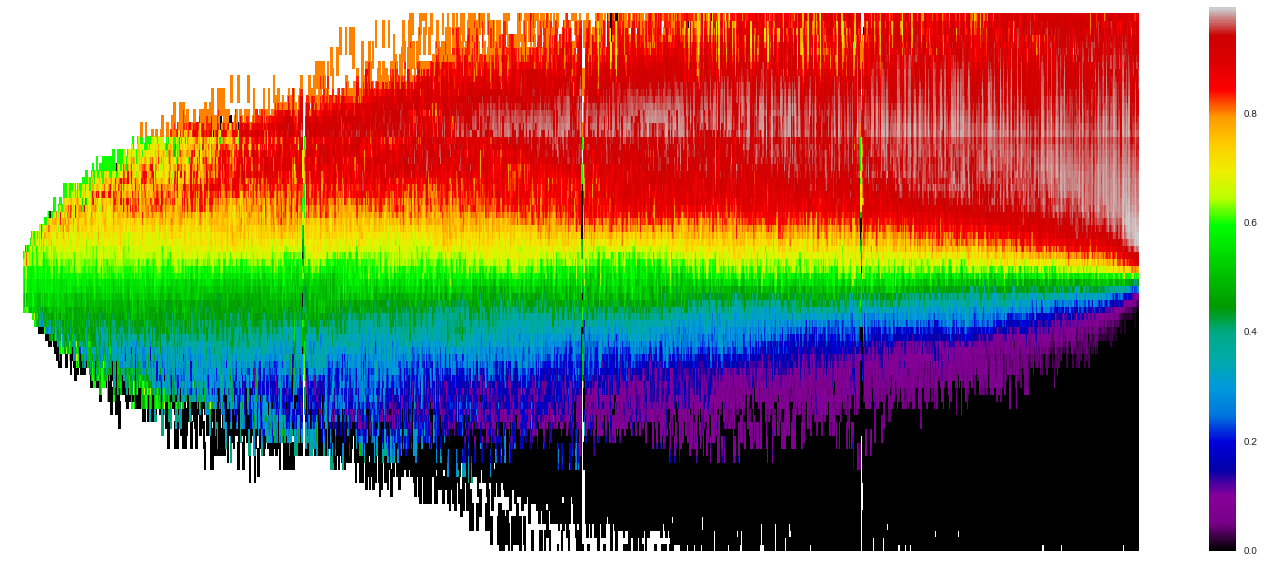

In [34]:
plt.figure(figsize=(25, 10))
plt.axis('off')
sns.heatmap(win_perc, cmap='spectral')
plt.show()